# Assignment - Week 4 Of Applied Data Science Capstone

Installing required Liabraries

In [ ]:
!conda install -c conda-forge lxml --yes
!conda install -c conda-forge geopy --yes
print("All Packages Installed")

In [110]:
from geopy.geocoders import Nominatim
import pandas as pd
import numpy as np
from lxml import etree
import folium
from pandas.io.json import json_normalize
import requests
from sklearn import preprocessing
from sklearn.metrics import jaccard_similarity_score as js
import matplotlib.pyplot as plt
from sklearn import metrics
print("All Liabraries imported")

All Liabraries imported


In [97]:
from IPython.display import HTML, display
print('done')

done


Collecting Coordinates For the city of Toronto and New York city

In [111]:
Taddress = 'Toronto'
geolocator = Nominatim(user_agent="foursquare_agent")
Tlocation = geolocator.geocode(Taddress)
Tlatitude = Tlocation.latitude
Tlongitude = Tlocation.longitude
print('The geogrTorontoapical coordinate of Toronto are {}, {}.'.format(Tlatitude, Tlongitude))

Naddress = 'New York, NY'
geolocator = Nominatim(user_agent="foursquare_agent")
Nlocation = geolocator.geocode(Naddress)
Nlatitude = Nlocation.latitude
Nlongitude = Nlocation.longitude
print('The geogrTorontoapical coordinate of New York City are {}, {}.'.format(Nlatitude, Nlongitude))

The geogrTorontoapical coordinate of Toronto are 43.6534817, -79.3839347.
The geogrTorontoapical coordinate of New York City are 40.7127281, -74.0060152.


Defining Foursqure Credentials and creating dataframe for both cities.

In [112]:
CLIENT_ID = 'LKYJH3XKT5AOOD3WACGD5TIMMUZC32L5DIWQY22JK30S3WRZ' #  Foursquare ID
CLIENT_SECRET = 'NDZHIFUHDONYDXAEHV3GPPOQPCJXJJNYPY5ZD5KLZRIPXB0Z' #  Foursquare Secret
LIMIT = 100
VERSION = '20180604'

radius = 1000
Turl = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, Tlatitude, Tlongitude, VERSION,radius, LIMIT)
Nurl = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, Nlatitude, Nlongitude, VERSION,radius, LIMIT)

Tresults = requests.get(Turl).json()
Nresults = requests.get(Nurl).json()

print('credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
Tvenues = Tresults['response']['venues']
Nvenues = Nresults['response']['venues']
# tranform venues into a dataframe
Tdataframe = pd.json_normalize(Tvenues)
Ndataframe = pd.json_normalize(Nvenues)
print(Tdataframe.shape)
print(Ndataframe.shape)
Ndataframe.head(2)

credentails:
CLIENT_ID: LKYJH3XKT5AOOD3WACGD5TIMMUZC32L5DIWQY22JK30S3WRZ
CLIENT_SECRET:NDZHIFUHDONYDXAEHV3GPPOQPCJXJJNYPY5ZD5KLZRIPXB0Z
(67, 18)
(100, 25)


,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.distance,...,location.formattedAddress,venuePage.id,location.labeledLatLngs,location.neighborhood,delivery.id,delivery.url,delivery.provider.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.icon.name
0,3fd66200f964a520d8f11ee3,City Hall Park,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",v-1606744772,False,17 Park Row,btwn Broadway & Centre St,40.711893,-74.007792,176,...,"[17 Park Row (btwn Broadway & Centre St), New ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4a676321f964a52051c91fe3,New York City Hall,"[{'id': '4bf58dd8d48988d129941735', 'name': 'C...",v-1606744772,False,260 E Broadway,at Murray St,40.712659,-74.005880,13,...,"[260 E Broadway (at Murray St), New York, NY 1...",186051114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


From the above Foursquare Data we can find that there are more establishments in New York City Than in city of Toronto in radious of 1000.\
Lets refine the dataframe now for better understanding of the data

In [113]:
# keep only columns that include venue name, and anything that is associated with location
Tfiltered_columns = ['name', 'categories'] + [col for col in Tdataframe.columns if col.startswith('location.')] + ['id']
Tdataframe_filtered = Tdataframe.loc[:, Tfiltered_columns]
# function that extracts the category of the venue
def get_category_type(row):
    try:
        Tcategories_list = row['categories']
    except:
        Tcategories_list = row['venue.categories']
    if len(Tcategories_list) == 0:
        return None
    else:
        return Tcategories_list[0]['name']
# filter the category for each row
Tdataframe_filtered['categories'] = Tdataframe_filtered.apply(get_category_type, axis=1)
# clean column names by keeping only last term
Tdataframe_filtered.columns = [column.split('.')[-1] for column in Tdataframe_filtered.columns]
#Tdataframe_filtered.city=Tdataframe_filtered.city.replace(np.nan,'Toronto')


Nfiltered_columns = ['name', 'categories'] + [col for col in Ndataframe.columns if col.startswith('location.')] + ['id']
Ndataframe_filtered = Ndataframe.loc[:, Nfiltered_columns]
# function that extracts the category of the venue
def get_category_type(row):
    try:
        Ncategories_list = row['categories']
    except:
        Ncategories_list = row['venue.categories']
    if len(Ncategories_list) == 0:
        return None
    else:
        return Ncategories_list[0]['name']
# filter the category for each row
Ndataframe_filtered['categories'] = Ndataframe_filtered.apply(get_category_type, axis=1)
# clean column names by keeping only last term
Ndataframe_filtered.columns = [column.split('.')[-1] for column in Ndataframe_filtered.columns]

Tdataframe_filtered.head(2)

,name,categories,lat,lng,labeledLatLngs,distance,cc,country,formattedAddress,address,crossStreet,postalCode,city,state,neighborhood,id
0,City Hall Council Chambers,City Hall,43.651827,-79.383949,"[{'label': 'display', 'lat': 43.65182710471462...",184,CA,Canada,[Canada],NaN,NaN,NaN,NaN,NaN,NaN,4c093ee0340720a153728493
1,Toronto City Hall,City Hall,43.653140,-79.383967,"[{'label': 'display', 'lat': 43.65313989695342...",38,CA,Canada,"[100 Queen St. W. (at Bay St.), Toronto ON M5H...",100 Queen St. W.,at Bay St.,M5H 2N2,Toronto,ON,NaN,4ad4c05ef964a5208ff620e3


Lets visualize the Venues of both cities in Geographical map.

## City Of Toronto and its Venues

In [118]:
venues_map = folium.Map(location=[Tlatitude, Tlongitude], zoom_start=17)
folium.CircleMarker(
    [Tlatitude, Tlongitude],
    
    color='red',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the banks as blue circle markers
for lat, lng, label in zip(Tdataframe_filtered.lat, Tdataframe_filtered.lng, Tdataframe_filtered.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)
# display map
venues_map

## New York City and its Venues

In [119]:
venues_map = folium.Map(location=[Nlatitude, Nlongitude], zoom_start=15) 

folium.CircleMarker(
    [Nlatitude, Nlongitude],
    
    color='red',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the banks as blue circle markers
for lat, lng, label in zip(Ndataframe_filtered.lat, Ndataframe_filtered.lng, Ndataframe_filtered.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

Evaluating Both Dataframes to find the similarities between both cities.

In [120]:
N_sim = pd.DataFrame({'categories':Ndataframe_filtered.name.groupby(Ndataframe_filtered['categories']).count().index, 'Ncount':Ndataframe_filtered.name.groupby(Ndataframe_filtered['categories']).count().values})
T_sim = pd.DataFrame({'categories':Tdataframe_filtered.name.groupby(Tdataframe_filtered['categories']).count().index, 'Tcount':Tdataframe_filtered.name.groupby(Tdataframe_filtered['categories']).count().values})
sim = pd.DataFrame({'categories':Tdataframe_filtered.categories.append(Ndataframe_filtered.categories).drop_duplicates()})
sim=sim.merge(T_sim,how= 'left')
sim=sim.merge(N_sim,how='left')
sim.fillna(0,inplace=True)
sim

,categories,Tcount,Ncount
0,City Hall,5.0,2.0
1,Government Building,1.0,5.0
2,Playground,2.0,0.0
3,Gym,1.0,0.0
4,Garden,1.0,0.0
...,...,...,...
75,Bus Line,0.0,1.0
76,Professional & Other Places,0.0,2.0
77,College Lab,0.0,1.0
78,Moving Target,0.0,1.0


We have Successfully created one dataframe with all Categries of venues from both cities and listed the counts of venues of both cities seperately.

Lets Visualize the Data in Bar Chart. Venues and their counts from Both cities are Ploted here.

<AxesSubplot:xlabel='categories'>

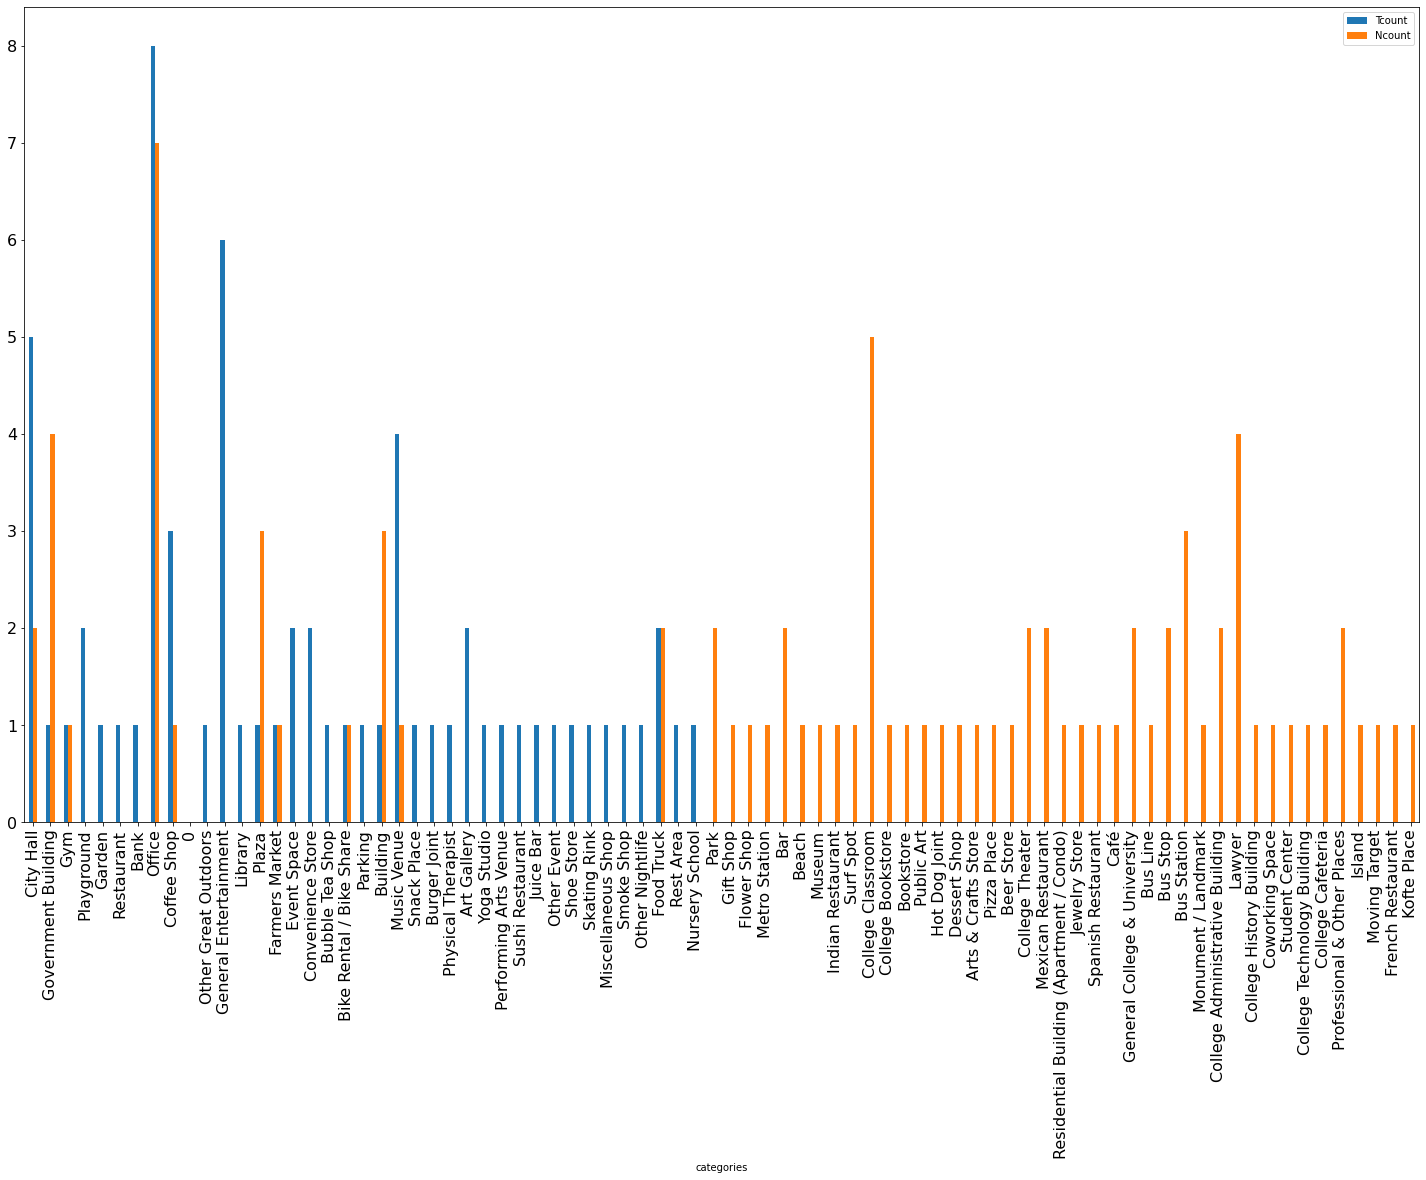

In [26]:
fig, ax = plt.subplots()
sim.plot.bar(x = 'categories', y = ['Tcount', 'Ncount'], rot = 90, ax = ax,figsize=(25, 15),legend=True, fontsize=16)

 Now we will find the __Jaccard Similarity score__ of both cities to find the similarity level between them.

In [121]:
print('The percentage of similarity score between both countries are {} which means both cities are not at all similar based on the Foursquare Data.'.format(js(sim.Tcount, sim.Ncount)*100))

The percentage of similarity score between both countries are 5.0 which means both cities are not at all similar based on the Foursquare Data.


## Finding The Best location for Opening A BANK

We will use the Fousquare API again to collect the Data of both cities using Search Query contaiing key Word "Bank" and "Finance" since our goal is to find the perfect spot for opening a Banking Institution.

In [92]:
search_query1 = 'bank','finance'
Turl = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, Tlatitude, Tlongitude, VERSION, search_query1,radius, LIMIT)
Nurl = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, Nlatitude, Nlongitude, VERSION, search_query1,radius, LIMIT)
Tresults = requests.get(Turl).json()
Nresults = requests.get(Nurl).json()


Tvenues = Tresults['response']['venues']
Nvenues = Nresults['response']['venues']

# tranform venues into a dataframe
Tdataframe = pd.json_normalize(Tvenues)
Ndataframe = pd.json_normalize(Nvenues)

# keep only columns that include venue name, and anything that is associated with location
Tfiltered_columns = ['name', 'categories'] + [col for col in Tdataframe.columns if col.startswith('location.')] + ['id']
Tdataframe_filtered = Tdataframe.loc[:, Tfiltered_columns]
# function that extracts the category of the venue
def get_category_type(row):
    try:
        Tcategories_list = row['categories']
    except:
        Tcategories_list = row['venue.categories']
    if len(Tcategories_list) == 0:
        return None
    else:
        return Tcategories_list[0]['name']
# filter the category for each row
Tdataframe_filtered['categories'] = Tdataframe_filtered.apply(get_category_type, axis=1)
# clean column names by keeping only last term
Tdataframe_filtered.columns = [column.split('.')[-1] for column in Tdataframe_filtered.columns]

Nfiltered_columns = ['name', 'categories'] + [col for col in Ndataframe.columns if col.startswith('location.')] + ['id']
Ndataframe_filtered = Ndataframe.loc[:, Nfiltered_columns]
# function that extracts the category of the venue
def get_category_type(row):
    try:
        Ncategories_list = row['categories']
    except:
        Ncategories_list = row['venue.categories']
    if len(Ncategories_list) == 0:
        return None
    else:
        return Ncategories_list[0]['name']
# filter the category for each row
Ndataframe_filtered['categories'] = Ndataframe_filtered.apply(get_category_type, axis=1)
# clean column names by keeping only last term
Ndataframe_filtered.columns = [column.split('.')[-1] for column in Ndataframe_filtered.columns]

print(Tdataframe_filtered.shape)
print(Ndataframe_filtered.shape)
Ndataframe_filtered.head(2)

(50, 16)
(50, 16)


,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,Bank of America,Bank,261 Broadway,Warren St,40.713757,-74.006885,"[{'label': 'display', 'lat': 40.71375680589482...",136,10007,US,New York,NY,United States,"[261 Broadway (Warren St), New York, NY 10007,...",NaN,4cd8c8b97d4546884c9beded
1,Bank Sultra Cabang New York,None,NaN,NaN,40.713131,-74.005941,"[{'label': 'display', 'lat': 40.7131309, 'lng'...",45,NaN,US,New York,NY,United States,"[New York, NY, United States]",NaN,54d15bb3498e3c4a6d4bbe61


Lets Plot the location of all Banks of New York in Folium.

In [103]:
venues_map1 = folium.Map(location=[Nlatitude, Nlongitude], zoom_start=15)
for lat, lng,in zip(Ndataframe_filtered.lat, Ndataframe_filtered.lng):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map1)

# display map
venues_map1

Now Lets Plot the location of all Banks of Toronto in Folium.

In [100]:
Tdataframe_filtered.head(2)

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,cc,city,state,country,formattedAddress,postalCode,neighborhood,id
0,Bank of Nova Scotia,Bank,392 Bay Street,Richmond,43.650685,-79.380853,"[{'label': 'display', 'lat': 43.65068457927371...",398,CA,Toronto,ON,Canada,"[392 Bay Street (Richmond), Toronto ON, Canada]",NaN,NaN,4c811edb6cc2b71380f4169b
1,BMO Bank of Montreal,Bank,100 King St W,at Bay St,43.648508,-79.380644,"[{'label': 'display', 'lat': 43.64850820653123...",613,CA,Toronto,ON,Canada,"[100 King St W (at Bay St), Toronto ON M5X 1A3...",M5X 1A3,NaN,4b1d68eef964a520201024e3


In [104]:
venues_map1 = folium.Map(location=[Tlatitude, Tlongitude], zoom_start=15) 
for lat1, lng1 in zip(Tdataframe_filtered.lat, Tdataframe_filtered.lng):
    folium.CircleMarker(
        [lat1, lng1],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map1)

# display map
venues_map1

Now Lets Find the average Distance Between the city Coordinates and Banks for Both Cities.

In [42]:
Tradius =Tdataframe_filtered.distance.mean()
Nradius =Ndataframe_filtered.distance.mean()
print('Mean Distance Between the city of New York and its banks is  {}'.format(Nradius))
print('Mean Distance Between the city of Toronto and its banks is  {}'.format(Tradius))

Mean Distance Between the city of New York and its banks is  493.5
Mean Distance Between the city of Toronto and its banks is  607.12


Since We found the average mean distance between the cities and its bank, lets show it in the Map. The Red Circle In maps will be thhe ideal location for setting up a bank in City of Torornto and City of New York.

In [108]:
NB_map = folium.Map(location=[Nlatitude, Nlongitude], zoom_start=14)
#Adding a circle to the map with radious of average distance with the city and its Banks
folium.Circle(
    [Nlatitude, Nlongitude],
    color='red',
    radius =Nradius,
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(NB_map)

NB_map

Lets do The same for City of Toronto Also...

In [107]:
NB_map = folium.Map(location=[Tlatitude, Tlongitude], zoom_start=14)
#Adding a circle to the map with radious of average distance with the city and its Banks
folium.Circle(
    [Tlatitude, Tlongitude],
    color='red',
    radius =Tradius,
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(NB_map)

NB_map

Conclution: We can See From the last 2 Maps the ideal spot for Opening a bank. The Idea Behind the Red circle in this maps is to find the Neighbourhood where most of the Banks or financial institutions are Located. When choosing a spot for a Bank, Corporates only consider places with other Financial Institutions. Because Customers of similar interest, In this case customers of different Financial institues flow to such places. That is Why i choose the Place in Both cities where Most Banks or other Finanicail Institutions Located. The Key Words used for the Search Query is "bank" and "Finance" in this Case.



## Thank You